# Titanic competition

<a id="table_of_contents"></a>
## Table of contents

* [Titanic competition](#)
    * [Project overview](#project_overview)
        * [Short story](#)
        * [Goal](#)
        * [Data description](#)
    * [Introduce with data](#introduce)
        * [Import libs](#import_libs)
        * [Import data and first impression](#import_data)
        * [Brief conclusions](#brief_conclusions)
    * [Data preparetion](#data_preparation)

<a id="project_overview"></a>
## Project overview

The competition is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

<a id="data_description"></a>
### Data description

#### Variables


|# | Variable | Definition | Key |
|:-|:---------|:-----------|:----|		
|1 | survival |	Survival   | 0 = No, 1 = Yes |
|2 | pclass |	Ticket class |	1 = 1st, 2 = 2nd, 3 = 3rd |
|3 | sex |	Sex | |	
|4 | Age |	Age in years | | 	
|5 | sibsp | # of siblings / spouses aboard the Titanic | |
|6 | parch | # of parents / children aboard the Titanic | | 	
|7 | ticket | Ticket number | |
|8 | fare | Passenger fare | |
|9 | cabin | Cabin number | |
|10 | embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |


#### Variable Notes

    pclass: A proxy for socio-economic status (SES)
    1st = Upper
    2nd = Middle
    3rd = Lower

    age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

    sibsp: The dataset defines family relations in this way...
    Sibling = brother, sister, stepbrother, stepsister
    Spouse = husband, wife (mistresses and fiancés were ignored)

    parch: The dataset defines family relations in this way...
    Parent = mother, father
    Child = daughter, son, stepdaughter, stepson
    Some children travelled only with a nanny, therefore parch=0 for them.

[to the table of contents](#table_of_contents)


<a id="introduce"></a>
## Introduce with data

<a id="import_libs"></a>
### Import libs

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from numpy.random import RandomState

import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

<a id="import_data"></a>
### Import data and first impression

In [2]:
# let's check which files do we have
datasets_dir = '../datasets/titanic'

if not os.path.isdir(datasets_dir):
    datasets_dir = '/kaggle/input'
    
for dirname, _, filenames in os.walk(datasets_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../datasets/titanic/test.csv
../datasets/titanic/train.csv
../datasets/titanic/gender_submission.csv


#### Train dataset

In [3]:
# upload train dataset
df_train = pd.read_csv(os.path.join(datasets_dir, 'train.csv'))

# check shape of the dataset
print('Shape of the train dataset:', df_train.shape, end='\n\n')

# watch first 5 rows
print('First five rows of the train dataset:')
display(df_train.head())

Shape of the train dataset: (891, 12)

First five rows of the train dataset:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# train dataset info
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


#### Test dataset

In [5]:
# upload gender test dataset
df_test = pd.read_csv(os.path.join(datasets_dir, 'test.csv'))

# check shape of the dataset
print('Shape of the test dataset:', df_test.shape, end='\n\n')

# watch first 5 rows in it
print('First five rows in the test dataset:')
display(df_test.head())

Shape of the test dataset: (418, 11)

First five rows in the test dataset:


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
# test dataset info
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


#### Gender submission

In [7]:
# upload gender submission dataset
df_gender = pd.read_csv(os.path.join(datasets_dir, 'gender_submission.csv'))

# check shape of the dataset
print('Shape of the gender_submission dataset:', df_gender.shape, end='\n\n')

# watch first 5 rows in it
print('First five rows in the gender submission dataset:')
display(df_gender.head())

Shape of the gender_submission dataset: (418, 2)

First five rows in the gender submission dataset:


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


<a id="brief_conclusions"></a>
### Brief conclusions

So...

[to the table of contents](#table_of_contents)

<a id="data_preparation"></a>
## Data preparation

### Target feature

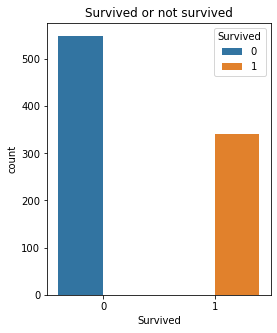

In [8]:
# Let's compare the number of survivos and the number of deceased on the graph:
plt.figure(figsize=(4,5))
sns.countplot(x='Survived', data=df_train, hue='Survived')
plt.title('Survived or not survived')
plt.show()

Unfortunately, the number of survivors is significantly less than the number of deceased.

### Duplicates
Let's check are there duplicates or not?

In [9]:
print(df_train.duplicated().sum())

0


#### Hidden duplicates

There is not any hidden duplicate

### Categorial features

In [42]:
cat_features = ['Pclass', 'Sex', 'Embarked']

In [58]:
df = df_train[['Survived', 'Pclass', 'Sex']]
display(df.head())

,Survived,Pclass,Sex
0,0,3,male
1,1,1,female
2,1,3,female
3,1,1,female
4,0,3,male


In [59]:
display(df.pivot_table(index='Pclass', columns='Survived', aggfunc='count'))

Sex     
Survived    0    1
Pclass            
1          80  136
2          97   87
3         372  119

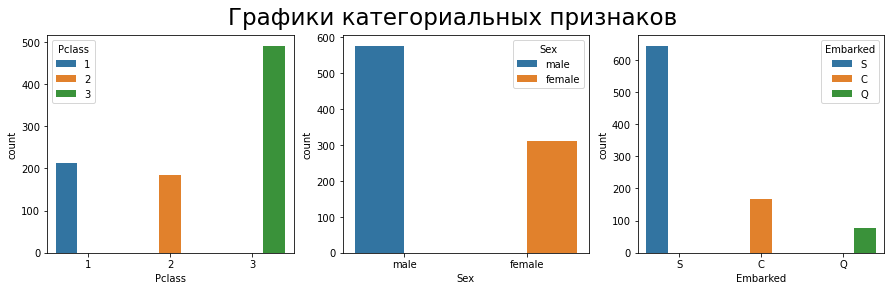

In [43]:
# create figure with three slots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

# do the monomer massive from the axis
for i, ax in enumerate(axes.flat):
    sns.countplot(x=cat_features[i], data=df_train[cat_features].dropna(axis=0), hue=cat_features[i], ax=ax)
    
fig.suptitle('Графики категориальных признаков', fontsize=23)
plt.show()

In [52]:
df = df_train.pivot_table(index='Survived', columns='Pclass', aggfunc='count')

In [53]:
display(df)

Age          Cabin        Embarked          Fare  ... PassengerId  \
Pclass      1   2    3     1   2  3        1   2    3    1  ...           3   
Survived                                                    ...               
0          64  90  270    59   3  6       80  97  372   80  ...         372   
1         122  83   85   117  13  6      134  87  119  136  ...         119   

          Sex          SibSp          Ticket           
Pclass      1   2    3     1   2    3      1   2    3  
Survived                                               
0          80  97  372    80  97  372     80  97  372  
1         136  87  119   136  87  119    136  87  119  

[2 rows x 30 columns]

sex: 0
sex: 1


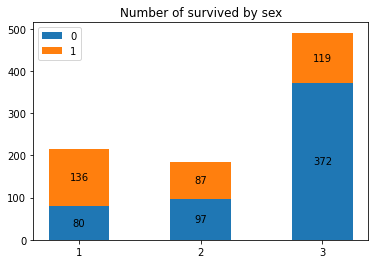

In [31]:
species = ('1', '2', '3')
width = 0.5
fig, ax = plt.subplots()
bottom = np.zeros(3)

for sex, sex_count in df.items():
    print('sex:',sex)
    p = ax.bar(species, sex_count, width, label=sex, bottom=bottom)
    bottom += sex_count

    ax.bar_label(p, label_type='center')

ax.set_title('Number of survived by sex')
ax.legend()

plt.show()

In [32]:
df = df_train.pivot_table(index='Survived', columns='Pclass', aggfunc='count')['Sex']

In [33]:
display(df)

Pclass,1,2,3
Survived,,,
0,80,97,372
1,136,87,119


sex: female
sex: male


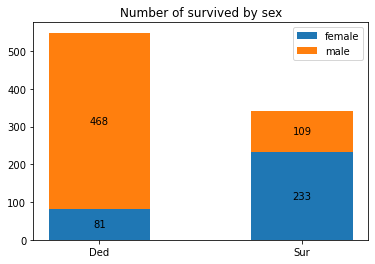

In [38]:
species = ('Ded', 'Sur')
width = 0.5
fig, ax = plt.subplots()
bottom = np.zeros(2)

for sex, sex_count in df.items():
    print('sex:',sex)
    p = ax.bar(species, sex_count, width, label=sex, bottom=bottom)
    bottom += sex_count

    ax.bar_label(p, label_type='center')

ax.set_title('Number of survived by sex')
ax.legend()

plt.show()

In [20]:
df_train[['Pclass', 'Survived']].head()

,Pclass,Survived
0,3,0
1,1,1
2,3,1
3,1,1
4,3,0


#### Sex

In [35]:
df = df_train.pivot_table(index='Survived', columns='Sex', values='PassengerId', aggfunc='count')
df.head()

Sex,female,male
Survived,,
0,81,468
1,233,109


sex: female
sex: male


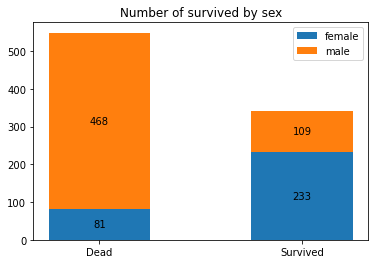

In [36]:
species = ('Dead', 'Survived')
width = 0.5
fig, ax = plt.subplots()
bottom = np.zeros(2)

for sex, sex_count in df.items():
    print('sex:',sex)
    p = ax.bar(species, sex_count, width, label=sex, bottom=bottom)
    bottom += sex_count

    ax.bar_label(p, label_type='center')

ax.set_title('Number of survived by sex')
ax.legend()

plt.show()

### Numerical features

In [ ]:
display(df_train.describe())

### Age

In [ ]:
df_train['Age'].hist()
plt.show()

In [ ]:
df_train['Ticket'].duplicated().sum()

In [ ]:
df_train.pivot_table(index='Ticket', aggfunc='count').head()

In [ ]:

i, ax = plt.subplots(figsize=(8,6))
print(ax, i)
class_frequency = df_train['Survived'].value_counts(normalize=True)
print(class_frequency.index)
ax.bar(class_frequency.index, class_frequency.values, align='edge')
# ax.bar(df_train['Survived'], bins=2)
plt.show()

In [ ]:
fig, ax = plt.subplots()
species = ('Dead', 'Survived')

width = 0.5
df = df_train.pivot_table(index='Survived', aggfunc='count')['Name']
print(df)
ax.bar(species, df, width)
plt.show()